In [1]:
from word2vec_models import TaigaStihiModel

embedding = TaigaStihiModel()

In [2]:
from data_sets.positive_meaning_corpus import PositiveMeaningCorpus
from data_sets import TaigaStihiCorpus


positive_corpus = PositiveMeaningCorpus(TaigaStihiCorpus(None), embedding, '/Volumes/UNTITLED/positive.txt')

In [3]:
count = 1
while True:
    count += 1
    print(count)
    positive_corpus.generate(100)

2
Начало обучения: 2022-12-01 08:08:05.612232
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
26

KeyboardInterrupt: 

In [3]:
positive_count = 100000
positive_corpus = iter(positive_corpus)
positive_data = [next(positive_corpus) for _ in range(positive_count)]

In [4]:
len(positive_data)

100000

In [4]:
from data_sets.negative_meaning_corpus import NegativeMeaningCorpus


negative_corpus = NegativeMeaningCorpus(embedding, '/Volumes/UNTITLED/negative.txt')

In [ ]:
for index in range(65):
    print(index)
    negative_corpus.generate(1000)

0


In [5]:
negative_count = 70000
negative_corpus = iter(negative_corpus)
negative_data = [next(negative_corpus) for _ in range(negative_count)]

In [10]:
len(negative_data)

70000

In [6]:
def func_chunk(lst, n):
    chunked = []
    for x in range(0, len(lst), n):
        e_c = lst[x : n + x]

        if len(e_c) < n:
            e_c = e_c + [None for y in range(n - len(e_c))]
        chunked.append(np.array(e_c))

    return chunked

In [7]:
import numpy as np
from random import shuffle

all_data =  positive_data + negative_data
shuffle(all_data)

train = all_data[:160000]
validation = all_data[160000:]


# TODO оптимизировать
def matrix_to_np_matrix(float_matrix: [[float]]):
    return np.array([np.array(func_chunk(item, 300)) for item in float_matrix])
# TODO оптимизировать
def list_to_np_matrix(float_list: [float]):
    return np.array([np.array([item]) for item in float_list])

x_train, y_train = list(zip(*train))
x_train = matrix_to_np_matrix(x_train)
y_train = list_to_np_matrix(y_train)


x_validation, y_validation = list(zip(*validation))
x_validation = matrix_to_np_matrix(x_validation)
y_validation = list_to_np_matrix(y_validation)

In [12]:
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras import Sequential, Input

model = Sequential()
model.add(Conv1D(300, 5, input_shape=(5, 300),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=3, padding='same'))
model.add(Conv1D(100, 5, input_shape=(5, 100),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')

In [13]:
history = model.fit(x_train, y_train,
                    batch_size=1000,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_validation, y_validation))

Epoch 1/10
160/160 [==============================] - 12s 73ms/step - loss: 0.0223 - accuracy: 0.9766 - val_loss: 0.0055 - val_accuracy: 0.9931
Epoch 2/10
160/160 [==============================] - 12s 77ms/step - loss: 0.0040 - accuracy: 0.9951 - val_loss: 0.0051 - val_accuracy: 0.9932
Epoch 3/10
160/160 [==============================] - 12s 73ms/step - loss: 0.0024 - accuracy: 0.9973 - val_loss: 0.0044 - val_accuracy: 0.9941
Epoch 4/10
160/160 [==============================] - 11s 71ms/step - loss: 0.0018 - accuracy: 0.9979 - val_loss: 0.0037 - val_accuracy: 0.9951
Epoch 5/10
160/160 [==============================] - 12s 77ms/step - loss: 0.0015 - accuracy: 0.9982 - val_loss: 0.0035 - val_accuracy: 0.9956
Epoch 6/10
160/160 [==============================] - 13s 78ms/step - loss: 0.0013 - accuracy: 0.9985 - val_loss: 0.0034 - val_accuracy: 0.9958
Epoch 7/10
160/160 [==============================] - 12s 73ms/step - loss: 0.0013 - accuracy: 0.9986 - val_loss: 0.0035 - val_accuracy:

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

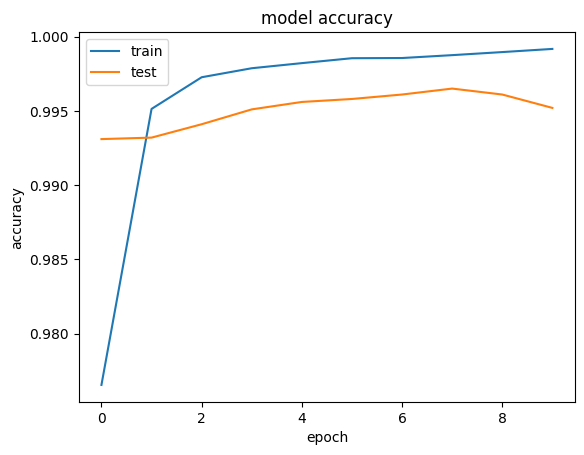

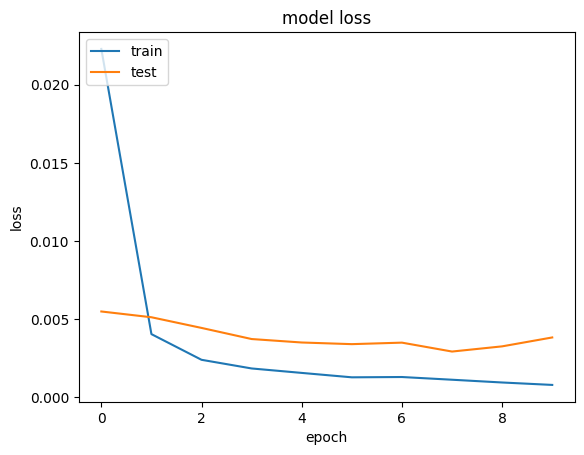

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save('CNN_taiga_stihi.h5')

In [22]:
from data_sets.utils import word_list_to_vec
sentence_one = 'привычка мост порог крюк кий'.split(' ')
# sentence_one = [choice(NegativeCorpus().vocab) for _ in range(5)]
# print(sentence_one)
word2vec_sentence_one = func_chunk(word_list_to_vec(embedding, sentence_one), 300)

sentence_two = ['мама', 'мыла', 'раму', 'за', 'окном']
# print(sentence_two)
word2vec_sentence_two = func_chunk(word_list_to_vec(embedding, sentence_two), 300)

# print(word2vec_sentence_one)
np_sentence = np.array([np.array(word2vec_sentence_one), np.array(word2vec_sentence_two)])
model.predict(np_sentence)

1/1 [==============================] - 0s 19ms/step


array([[0.2611095],
       [1.       ]], dtype=float32)